# CNN Cancer Detection

## Introduction:

This project will include a binary image classification problem where we will distinguish metastatic cancer in small image patches taken from larger digital pathology scans. Computer vision machine learning techniques can be used to improve cancer detection in lymph nodes. An algorithm will be created to be able to identify these scans and will be predicted on a sample dataset of images on Kaggle to test performance. Specifically, a Convolutional Neural Network (CNN) will be used which is a specialized deep learning algorithm designed for object recognition. This notebook with go through the steps of describing the data, exploratory data analysis, model architecture, results, analysis, and conclusion. The data is sourced from [Kaggle Competitions](https://www.kaggle.com/c/histopathologic-cancer-detection/overview) with a train labels file for the ground truths of the images in the train folder. I will be predicting the labels for the images in the test folder. A positive label would be when a 32x32 pixel region of a patch contains at least one pixel of tumor tissue. Let us start with loading the required packages and data into the notebook. 

The link to the [notebook on GitHub](https://github.com/aryanbashar/CNN_Cancer_Detection).

#### Required Packages:

In [2]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import gc
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from PIL import Image
from PIL import ImageDraw
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

### Load in Data and Exploratory Data Analysis (EDA):

In [3]:
# The first 5 rows of the train_labels sheet
df_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
# Print the shape and columns of df_labels
print(df_labels.shape)
print(df_labels.columns)

(220025, 2)
Index(['id', 'label'], dtype='object')


In [5]:
# Load in the folders for training and testing
train = "/kaggle/input/histopathologic-cancer-detection/train/"
test = "/kaggle/input/histopathologic-cancer-detection/test"

print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


The number of images matches the amount seen on the Kaggle site. Let us see now how many of each label there are in the train labels:

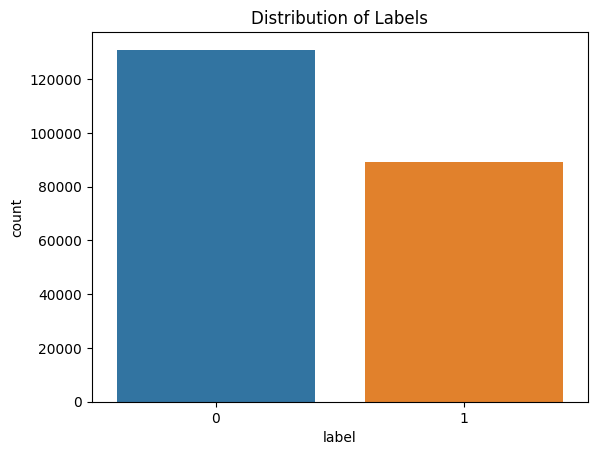

In [6]:
# Count the amount of labels in the data 
sns.countplot(x='label', data=df_labels)
plt.title('Distribution of Labels')
plt.show()

There are much more non-malignant cases (label 0) than malignant cases (label 1). It is good to take this into account and if we decide to balance it prior to model building. 

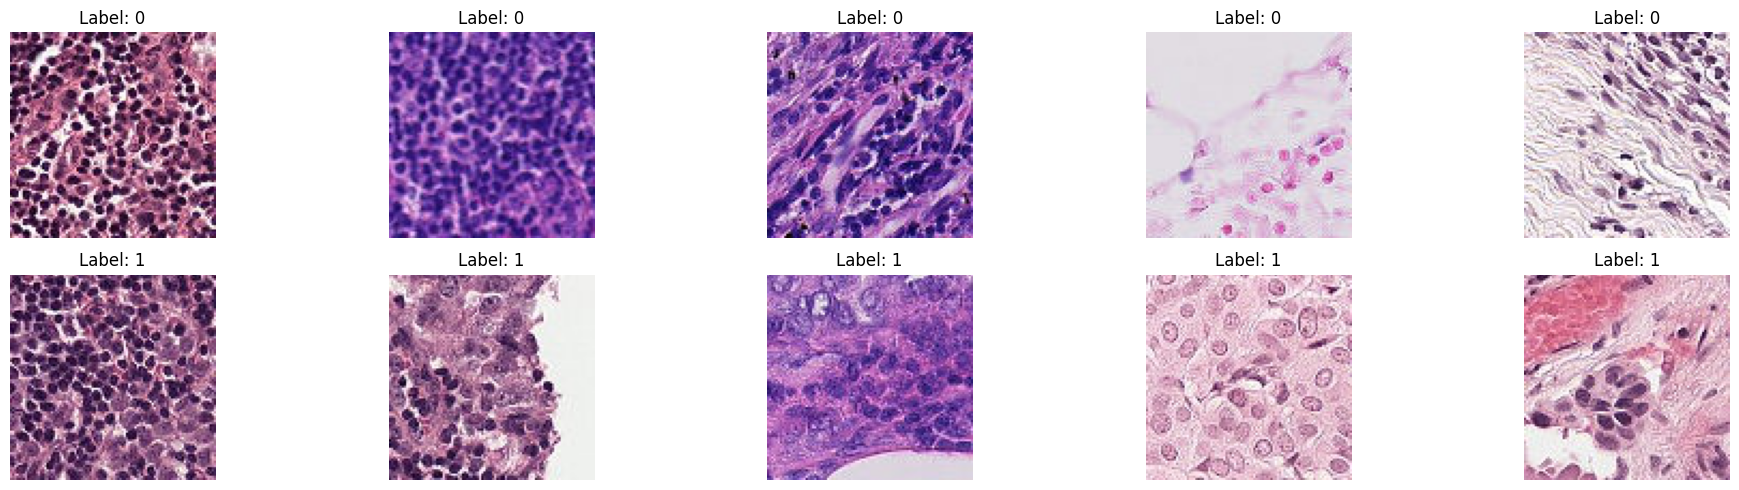

In [7]:
# Let us see some examples of photos from each label

def display_sample_images(df_labels, train, num_images=5):
    fig, axs = plt.subplots(2, num_images, figsize=(20, 5))
    for i, label in enumerate(df_labels['label'].unique()):
        sample_ids = df_labels[df_labels['label'] == label].sample(num_images)['id'].values
        for j, id in enumerate(sample_ids):
            img_path = os.path.join(train, id + '.tif')
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Label: {label}')
    plt.tight_layout()
    plt.show()

display_sample_images(df_labels, train)

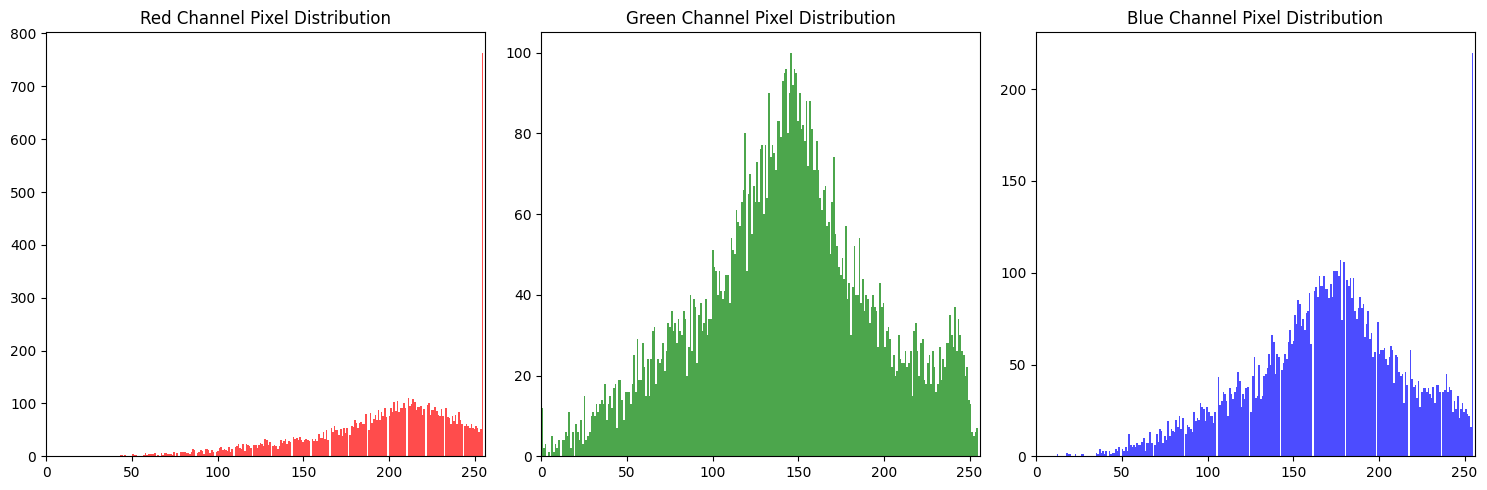

In [8]:
def display_pixel_distribution(df_labels, train, id):
    img_path = os.path.join(train, id + '.tif')
    img = Image.open(img_path)
    img_array = np.array(img)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['Red', 'Green', 'Blue']
    for i, color in enumerate(colors):
        axs[i].hist(img_array[:, :, i].ravel(), bins=256, color=color.lower(), alpha=0.7)
        axs[i].set_title(f'{color} Channel Pixel Distribution')
        axs[i].set_xlim([0, 256])
    plt.tight_layout()
    plt.show()

# Example of pixel distribution from a chosen photo in train label
display_pixel_distribution(df_labels, train, '/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5')

Check for missing values in the data and prepare data:

In [9]:
# Check for missing values
missing_values = df_labels.isnull().sum()
missing_values

id       0
label    0
dtype: int64

In [10]:
# Exact Count of the number of labels of 0 and 1
df_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [11]:
# Adding the .tif extension to each id in the data
df_labels['id'] = df_labels['id'].apply(lambda x: f"{x}.tif")

In [12]:
# Check to see that the .tif was added
print(df_labels['id'].head())

0    f38a6374c348f90b587e046aac6079959adf3835.tif
1    c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2    755db6279dae599ebb4d39a9123cce439965282d.tif
3    bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4    068aba587a4950175d04c680d38943fd488d6a9d.tif
Name: id, dtype: object


In [13]:
df_labels['label'] = df_labels['label'].astype(str)

Test to see if adding .tif to training dataset can match with the train photos:

In [14]:
# Use a known file ID after adding .tif
file_id = '00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif'
# Double check that the file_id is in df_labels
print(file_id in df_labels['id'].values)

True


As we saw in the bar graph earlier, the amount of non-malignant photos were more than malignant. This will calculate the amount of each type of photo so that we can balance it in the model:

In [23]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_labels['label']),
    y=df_labels['label']
)

# Convert class weights to a dictionary to pass to model.fit
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.840380267057781, 1: 1.234472659537462}


### First Model:

 For the first model, we will use a typical convolutional neural network (CNN) constructed for image classification tasks. It is set up to take features out from images and make predictions, which in this case is the presence of cancer cells. 
* **Input Shape** – defines the shape of the images that will enter the model, at 64 x 64 pixels and 3 color channels.
* **Convolutional Layers** – These layers accomplish the convolution operation by applying filters to the input to create feature maps. The filters are important in capturing patterns and complex features. The Rectified Linear Unit (ReLU) is used to establish non-linearity.  
* **Max Pooling Layers** – These layers are important in reducing the spatial dimensions of the input volume and helps with computational load and memory usage. 
* **Batch Normalization** – This occurs after the convolutional layers and normalizes the output to help alleviate the learning process and lower the required amount of training epochs needed for convergence. 
* **Flatten Layer** – Changes the 3D output into a 1D tensor required by the fully connected layers.
* **Fully Connected Dense Layers** – These take the flattened input from above and displays them on a 512-dimensional space, so that the network can learn non-linear combinations of the high-level features. The dropout is a regularization technique used to help prevent overfitting. 
* **Output Layer** – This is the final layer that is a single neuron with a sigmoid activation function, important for binary classification. It puts out a probability of the input having occurrence of cancer. 


In [20]:
# Convolutional Neural Network 
model = Sequential([
    Input(shape=(64, 64, 3)), # Shape of input photo
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


## Preprocessing:

The model compile step is important for preparing the model for training. The optimizer changes the attributes of the neural network to decrease the quantity of losses. Adam is an optimization algorithm that can handle noisy problems and it is known for its efficiency. The loss functions measures how well the model performs, and the metrics are used to observe and assess the execution of the model as well. 

In [21]:
# Adam Optimizer
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


The ImageDataGenerator is especially useful for image data preprocessing and augmentation. It normalizes the image pixel values through the rescaling. Data augmentation increases the size and variability of the training dataset to avoid overfitting. The validation split indicates that 80% of the data will be used for the training set and 20% will be used for the validation set. This step allows us to efficiently load in and process the large number of images and introduce variability into the data. 

In [17]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2 # Splitting data into 80% training and 20% validation sets
)

### Model Training:

In [18]:
# 
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=train,
    x_col='id', # Column in dataframe that contains the filenames
    y_col='label', # Column in dataframe that contains the labels
    target_size=(64, 64),
    batch_size=256,
    class_mode='binary',
    subset='training'
)

Found 176020 validated image filenames belonging to 2 classes.


In [22]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=train,
    x_col='id', # Column in dataframe that contains the filenames
    y_col='label', # Column in dataframe that contains the labels
    target_size=(64, 64),
    batch_size=256,
    class_mode='binary',
    subset='validation'
)


Found 44005 validated image filenames belonging to 2 classes.


Standard model training which uses 10 epochs:

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights_dict # Calculated Earlier
)


Epoch 1/10
147/687 ━━━━━━━━━━━━━━━━━━━━ 21:45 2s/step - accuracy: 0.7554 - loss: 0.5664

W0000 00:00:1712681947.174043      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7722 - loss: 0.5263

W0000 00:00:1712683338.054391      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 2237s 3s/step - accuracy: 0.7722 - loss: 0.5263 - val_accuracy: 0.8193 - val_loss: 0.4156
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7930 - loss: 0.4797 - val_accuracy: 0.8210 - val_loss: 0.4081
Epoch 3/10


W0000 00:00:1712683817.820000      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 829s 1s/step - accuracy: 0.8138 - loss: 0.4271 - val_accuracy: 0.8410 - val_loss: 0.3651
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8828 - loss: 0.3118 - val_accuracy: 0.8210 - val_loss: 0.4452
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - accuracy: 0.8264 - loss: 0.3963 - val_accuracy: 0.8469 - val_loss: 0.3558
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8086 - loss: 0.3646 - val_accuracy: 0.8472 - val_loss: 0.3296
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 829s 1s/step - accuracy: 0.8346 - loss: 0.3796 - val_accuracy: 0.8534 - val_loss: 0.3421
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8672 - loss: 0.3187 - val_accuracy: 0.8646 - val_loss: 0.3299
Epoch 9/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 827s 1s/step - accuracy: 0.8426 - loss: 0.3633 - val_accuracy: 0.8411 - val_loss: 0.3759
Epoch 10/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8477 - loss: 0.3355 - val_accuracy: 0.8341 -

In [26]:
# Save the model
model.save('my_kaggle_model.h5')  

### Results of First Model:

In [39]:
first_val_loss, first_val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

171/171 ━━━━━━━━━━━━━━━━━━━━ 123s 721ms/step - accuracy: 0.8410 - loss: 0.3746


In [40]:
print(f'Validation loss: {first_val_loss}')
print(f'Validation accuracy: {first_val_accuracy}')

Validation loss: 0.37509387731552124
Validation accuracy: 0.8416483998298645


A validation loss of 0.3751 and a validation accuracy of 0.8416 indiciates a solid performance of the model. The accuracy means that the model predicted on the unseen validation data and was correct 84.16% of the time. The model fits the data relatively well but there are improvements that can be made. 

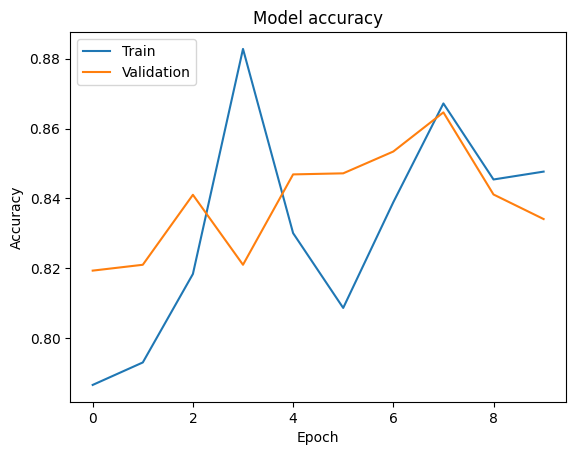

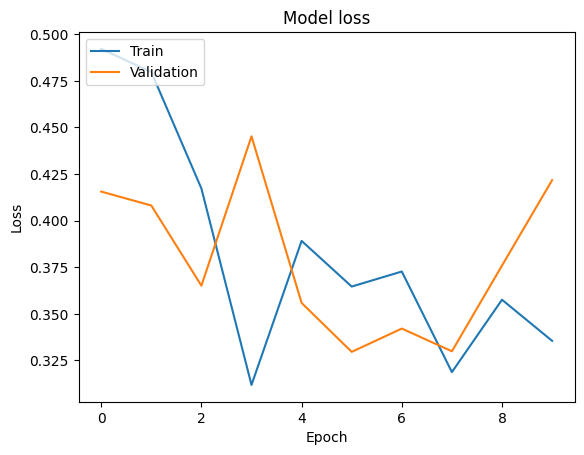

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
# Generate predictions for all your validation data
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

# Convert probabilities to binary predictions
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]

171/171 ━━━━━━━━━━━━━━━━━━━━ 134s 783ms/step


### Second Model:

Let us try a second model architecture to see how it compares to the first architecture. There will be more convolutional layers, which many capture more complex features. The dropout layers after the convolutional blocks can be used to help lower overfitting. It is also a different pattern for increasing the number of filters in the convolutional layers. The size of the dense layer is also changed prior to the final production. 
* The model starts with less filters but increases as it continues to help the network learn simple patterns before moving to more complex ones. 
* As stated before, more convolutional layers will help with preventing overfitting.
* The dense layer has less neurons than the first model, which will lower the complexity.


In [31]:
# The second model is adjusted with a more complex architecture

new_model = Sequential([
    Input(shape=(64, 64, 3)),  # Adjusted to the target size of the ImageDataGenerator
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

new_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [33]:
history_new_model = new_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights_dict # Calculated Earlier
)

Epoch 1/10
  2/687 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.4570 - loss: 0.7502   

W0000 00:00:1712688919.598673      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


648/687 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7096 - loss: 0.5518

W0000 00:00:1712689567.292042      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


686/687 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.7129 - loss: 0.5483

W0000 00:00:1712689602.558512      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 886s 1s/step - accuracy: 0.7131 - loss: 0.5481 - val_accuracy: 0.7414 - val_loss: 0.5452
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7734 - loss: 0.4320 - val_accuracy: 0.7555 - val_loss: 0.5528
Epoch 3/10


W0000 00:00:1712689785.680613      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 888s 1s/step - accuracy: 0.8136 - loss: 0.4206 - val_accuracy: 0.7900 - val_loss: 0.4553
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8672 - loss: 0.3507 - val_accuracy: 0.8210 - val_loss: 0.3814
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 816s 1s/step - accuracy: 0.8256 - loss: 0.3943 - val_accuracy: 0.7956 - val_loss: 0.4518
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7969 - loss: 0.3734 - val_accuracy: 0.8210 - val_loss: 0.3995
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 832s 1s/step - accuracy: 0.8349 - loss: 0.3759 - val_accuracy: 0.8138 - val_loss: 0.4210
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8281 - loss: 0.3873 - val_accuracy: 0.8079 - val_loss: 0.4212
Epoch 9/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - accuracy: 0.8429 - loss: 0.3612 - val_accuracy: 0.8035 - val_loss: 0.4548
Epoch 10/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8711 - loss: 0.2998 - val_accuracy: 0.8166 -

### Results of the Second Model:

In [34]:
val_loss, val_accuracy = new_model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

171/171 ━━━━━━━━━━━━━━━━━━━━ 124s 725ms/step - accuracy: 0.7987 - loss: 0.4733
Validation Loss: 0.47033438086509705
Validation Accuracy: 0.8013752102851868


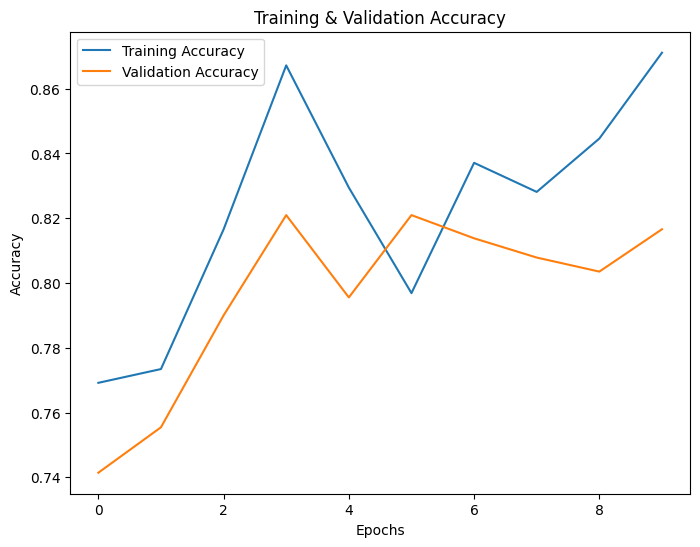

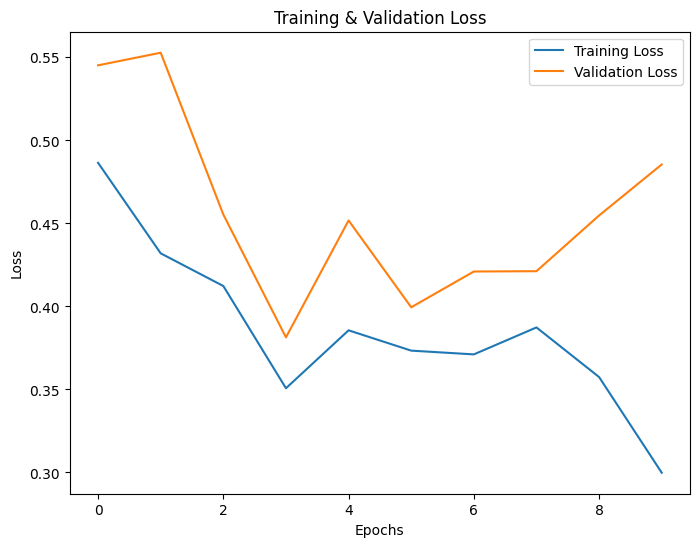

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(history_new_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_new_model.history['loss'], label='Training Loss')
plt.plot(history_new_model.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

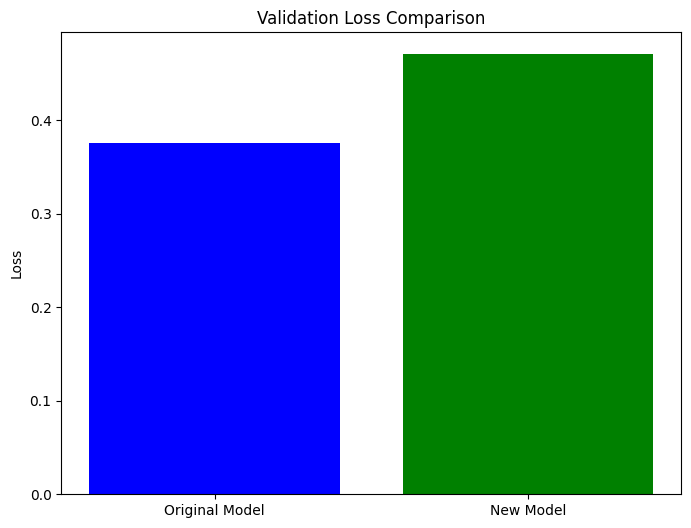

In [41]:
labels = ['Original Model', 'New Model']
loss_values = [first_val_loss, val_loss]

plt.figure(figsize=(8, 6))
plt.bar(labels, loss_values, color=['blue', 'green'])
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.show()

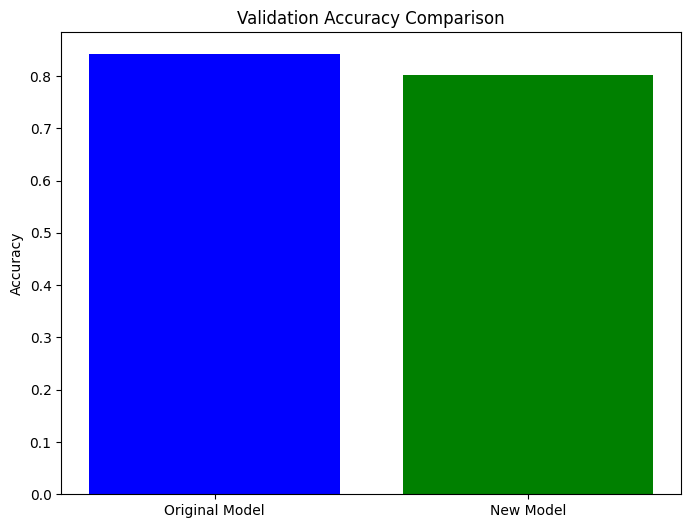

In [42]:
accuracy_values = [first_val_accuracy, val_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracy_values, color=['blue', 'green'])
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

## Discussion: 

The newer model performed worse than the more traditional first model. To summarize, the first model had a validation loss of about 0.3751 and a validation accuracy of about 84.16%, while the second model had a validation loss of 0.4703 and a validation accuracy of 80.14%. The original model had a lower validation loss and a higher validation accuracy and is evident in the above visualizations. To dissect this, we can investigate the increased model complexity. The second model had less filters than the first model, which are important for capturing fine details in the photos. The dense layer of the second model as also smaller, which would capture fewer complex patterns. The second model also increased dropout rates to help with overfitting, but too many dropouts could lead to underfitting. There are more convolutional layers in the second model, but it did not seem to help in this case to discover more complex structures. 

### Tuning the Hyperparamters:

Let us adjust aspects of the second model to see if we can improve how it works. The filter size will be increased which should let the network learn more complex features from the data. Likewise, the dense layer was increased, which will allow the model to process these complex features and extract more information or patterns from them. 

In [57]:
new_model = Sequential([
    Input(shape=(64, 64, 3)),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Increased from 16 to 32
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Increased from 16 to 32
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Increased from 32 to 64
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Increased from 32 to 64
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Increased from 64 to 128
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Increased from 64 to 128
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

The optimizer has also changed from Adam to Stochastic Gradient Descent (SGD), which may help with convergence and affect training setups.  

In [58]:
# SGD optimizer

new_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [59]:
history_new_model = new_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights_dict # Calculated Earlier
)

Epoch 1/20
  1/687 ━━━━━━━━━━━━━━━━━━━━ 5:57:17 31s/step - accuracy: 0.4648 - loss: 0.6920

W0000 00:00:1712701590.818905      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


464/687 ━━━━━━━━━━━━━━━━━━━━ 3:32 953ms/step - accuracy: 0.5403 - loss: 0.6860

W0000 00:00:1712702031.989053      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.5357 - loss: 0.6863

W0000 00:00:1712702241.678819      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 848s 1s/step - accuracy: 0.5357 - loss: 0.6863 - val_accuracy: 0.4036 - val_loss: 0.7372
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5664 - loss: 0.6463 - val_accuracy: 0.4585 - val_loss: 0.7148
Epoch 3/20


W0000 00:00:1712702414.850108      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


687/687 ━━━━━━━━━━━━━━━━━━━━ 696s 1s/step - accuracy: 0.5245 - loss: 0.6764 - val_accuracy: 0.5706 - val_loss: 0.6917
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5430 - loss: 0.6831 - val_accuracy: 0.4803 - val_loss: 0.6927
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 701s 1s/step - accuracy: 0.5774 - loss: 0.6575 - val_accuracy: 0.5912 - val_loss: 0.6319
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.6133 - loss: 0.6012 - val_accuracy: 0.5284 - val_loss: 0.6901
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 664s 960ms/step - accuracy: 0.5889 - loss: 0.6341 - val_accuracy: 0.5886 - val_loss: 0.6301
Epoch 8/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.5938 - loss: 0.5760 - val_accuracy: 0.5677 - val_loss: 0.6369
Epoch 9/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 659s 952ms/step - accuracy: 0.5911 - loss: 0.6292 - val_accuracy: 0.5860 - val_loss: 0.6292
Epoch 10/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.5625 - loss: 0.6454 - val_accura

In [60]:
val_loss, val_accuracy = new_model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

171/171 ━━━━━━━━━━━━━━━━━━━━ 123s 719ms/step - accuracy: 0.8145 - loss: 0.4004
Validation Loss: 0.4012545347213745
Validation Accuracy: 0.812774121761322


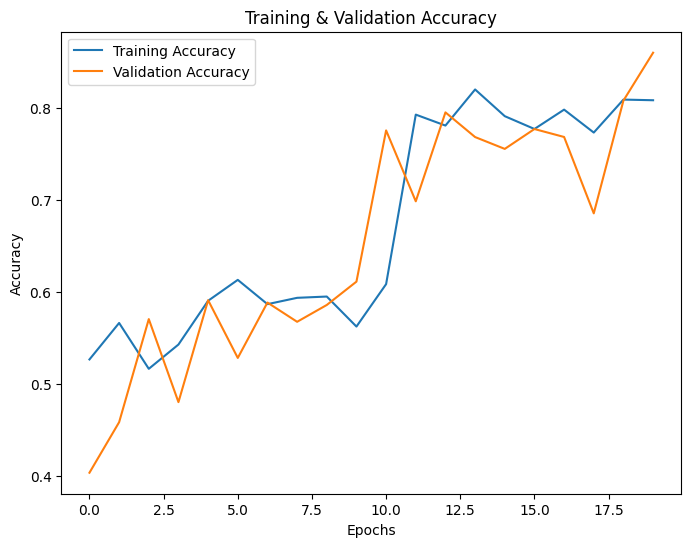

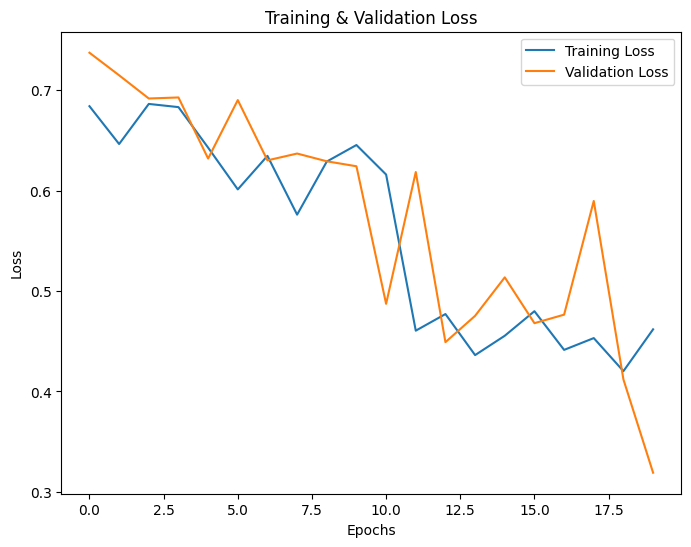

In [61]:
plt.figure(figsize=(8, 6))
plt.plot(history_new_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_new_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_new_model.history['loss'], label='Training Loss')
plt.plot(history_new_model.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Discussion:

The tuned model performed better than the second model but was not able to reach the performance of the first model. The Adam optimizer may have been able to converge quicker as it can alter learning rate while training occurs. The SGD optimizer is selective with the learning rate since it is fixed beforehand. The tuned model was more complex in architecture, but the original model was more balanced and may have suited this task better. 

Future steps that could be taken is to experiment with different learning rates for the SGD optimizer. Also, longer training time could have been compared to see if it helped the more complex model. There could have been some emphasis on regularization done prior to model building as well. There could have been some more adjustments done on the model architecture to develop the first model instead of trying a completely different architecture. 


## Conclusion:

This project provided the opportunity to explore Convolutional Neural Networks in an important sector of health care. Data science and deep learning has provided the ability to utilize digital pathology scans and identify metastatic cancer to help improve cancer detection in lymph nodes. It was seen that the typical CNN specialized for image classification tasks performed the best with three convolutional and max pooling layers, a flatten layer, two dense layers, and an output layer. We put together a model that was able to achieve a validation accuracy of 84.16% and further test it on unseen data through Kaggle. This outperformed the second model that used an increased filter size and increased dense layers even after further tuning of the parameters. It gave us the chance to see that a more complex model will not always automatically perform better. The hyperparameters of these models can be selective and it can be performance heavy to find the best combinations, especially if met with time restrictions in the real world. It is best to find a good balance that performs well on both the training data and unseen data. Further steps can be taken to utilize different techniques for preprocessing and introduce more robust models and hyperparameter tuning technologies. I hope to use this gained knowledge on CNNs to continue exploring image classification and use data to achieve new discoveries. 

## Citations:

O’Shea, K., & Nash, R. (2015). An introduction to convolutional neural networks. *arXiv (Cornell University).* https://arxiv.org/pdf/1511.08458.pdf

Srivastava, N., Hinton, G. E., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. *Journal of Machine Learning Research*, 15(1), 1929–1958. https://jmlr.csail.mit.edu/papers/volume15/srivastava14a/srivastava14a.pdf

Will Cukierski. (2018). Histopathologic Cancer Detection. *Kaggle*. https://kaggle.com/competitions/histopathologic-cancer-detection


### Prepare Submission File:

In [62]:
#create a dataframe to run the predictions
test_df = pd.DataFrame({'id':os.listdir(test)})
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [44]:
# Initialize the test ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Using the test path
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test,
    x_col="id",  # matches the column that contains the image file names
    y_col=None,  # No labels in test set
    target_size=(64, 64),  # matched with the model targeted size
    batch_size=256,
    class_mode=None,  
    shuffle=False  # to keep the order, so the predictions match the IDs
)

Found 57458 validated image filenames.


In [47]:
# Generate predictions for the test set
predictions = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)))

225/225 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step


In [49]:
# Remove the '.tif' end of the files
test_df['id'] = test_df['id'].str.replace('.tif', '', regex=False)

processed_predictions = [1 if x > 0.5 else 0 for x in predictions.flatten()]

# Create the submission 
submission_df = pd.DataFrame({
    "id": test_df['id'],  # Now contains IDs without .tif
    "label": processed_predictions
})

# Save the file
submission_df.to_csv('submission.csv', index=False)

In [63]:
# Generate predictions for the test set
predictions = new_model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)))

225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 679ms/step


In [64]:
# Remove the '.tif' ending on the files
test_df['id'] = test_df['id'].str.replace('.tif', '', regex=False)

processed_predictions = [1 if x > 0.5 else 0 for x in predictions.flatten()]

# Create the submission 
submission_df = pd.DataFrame({
    "id": test_df['id'],  # Now contains IDs without .tif
    "label": processed_predictions
})

# Save the file
submission_df.to_csv('submission_new_model.csv', index=False)